In [ ]:
from google.colab import files
def download_kaggle_key():
  files.upload()

download_kaggle_key()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats

 99% 801M/812M [00:05<00:00, 145MB/s]
100% 812M/812M [00:05<00:00, 146MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq test1.zip
!unzip -qq train.zip

In [ ]:
# Copying images to training, validation, and test directories
import os, shutil, pathlib

# Path to the directory where the original dataset was uncompressed
original_dir = pathlib.Path("train")

# directory for storing dataset to work on
new_base_dir = pathlib.Path("dogs-vs-cats-small")

In [ ]:
'''
Utility function to copy cat (and dog) images from index
start_index to index end_index to the subdirectory
new_base_dir/{subset_name}/cat (and /dog). The
"subset_name" will be either "train", "validation", or "test".
'''
def make_subset(subset_name, start_index, end_index):
    # Loop through a tuple containing ("cat, "dog").
    for category in ("cat", "dog"):

        # New directory called:
        # dogs-vs-cats/train/cat and afterwards dogs-vs-cats/train/dogs
        # dogs-vs-cats/validation/cat and afterwards dogs-vs-cats/validation/dogs
        # dogs-vs-cats/test/cat and afterwards dogs-vs-cats/test/dogs
        dir = new_base_dir / subset_name / category

        # Make folder for given directory.
        os.makedirs(dir)

        # An array of jpg names called cat.1.jpg, cat.2.jpg, etc and then dog.1.jpg, dog.2.jpg, etc...
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

        # Copy file from dogs-vs-cats/train/train/cat.1.jpg for example and paste it into dogs-vs-cats/train/cat/cat.1.jpg.
        # Apply this to every name in fnames and every category
        for fname in fnames:
            shutil.copyfile(src=original_dir /  fname, dst = dir / fname)

# Create training subset with first 1000 images of each category
make_subset("train", start_index=0, end_index=1000)

# Create validation subset with next 500 images of each category
make_subset("validation", start_index=1000, end_index=1500)

# Create test subset with next 1000 images of each category
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

# Use image_dataset_from_directory to turn images into preprocessed tensors
train_dataset = image_dataset_from_directory(
    directory=new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    directory=new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    directory=new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def CNN_Model():
    # Use a Functional Model API
    # Models expects RGB images of size 180 x 180 and 3 is for RGB channel
    inputs = keras.Input(shape=(180, 180, 3))

    # Rescale inputs to the [0, 1] range by dividing values by 255
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)

    # Max Pooling reduces the dimensionality of images by reducing the number
    # of pixels in the feature map from prev layer.
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

    # Flatten 3D outputs to 1D since dense layers processes vectors, which are 1D
    x = layers.Flatten()(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

model = CNN_Model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.h5",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
  )

Epoch 1/30
63/63 [==============================] - 217s 3s/step - loss: 0.7009 - accuracy: 0.5210 - val_loss: 0.6923 - val_accuracy: 0.5010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
63/63 [==============================] - 200s 3s/step - loss: 0.6898 - accuracy: 0.5340 - val_loss: 0.6798 - val_accuracy: 0.5380
Epoch 3/30
63/63 [==============================] - 198s 3s/step - loss: 0.6844 - accuracy: 0.5585 - val_loss: 0.6686 - val_accuracy: 0.5690
Epoch 4/30
63/63 [==============================] - 186s 3s/step - loss: 0.6693 - accuracy: 0.6275 - val_loss: 0.6393 - val_accuracy: 0.6290
Epoch 5/30
63/63 [==============================] - 196s 3s/step - loss: 0.6195 - accuracy: 0.6620 - val_loss: 0.6392 - val_accuracy: 0.6190
Epoch 6/30
63/63 [==============================] - 196s 3s/step - loss: 0.5929 - accuracy: 0.6815 - val_loss: 0.6148 - val_accuracy: 0.6620
Epoch 7/30
63/63 [==============================] - 177s 3s/step - loss: 0.5555 - accuracy: 0.7175 - val_loss: 0.6721 - val_accuracy: 0.6730
Epoch 8/30
63/63 [==============================] - 178s 3s/step - loss: 0.5350 - accuracy: 0.7385 - val_loss: 0.6035 - val_accuracy: 0.6800
Epoch 9/30
63

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")

    plt.title("Training and validation accuracy")

    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")

    plt.title("Training and validation loss")

    plt.legend()
    plt.show()

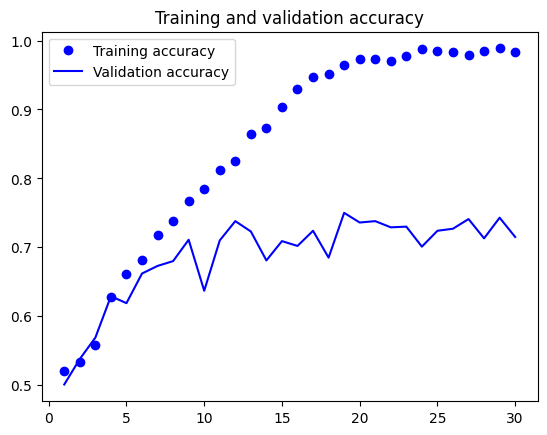

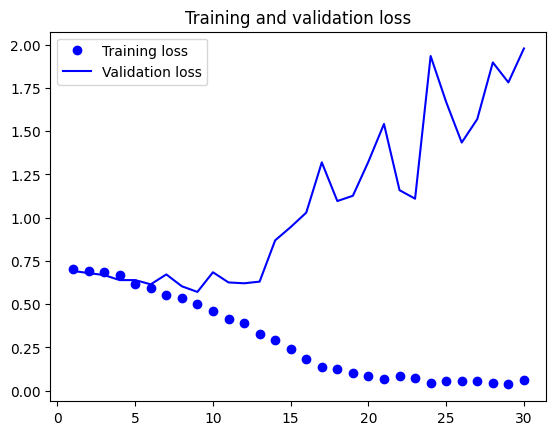

In [ ]:
plot_graph(history)

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)

print(f'Test accuracy: {test_acc:.3f}')

63/63 [==============================] - 48s 749ms/step - loss: 0.5906 - accuracy: 0.7010
Test accuracy: 0.701


In [ ]:
import keras
from keras import layers
# RandomFlip("horizontal") applies horizontal flipping to a random 50% of the images
# RandomRotation(0.1) rotates the images by a random value in the range [-10%, +10%]
# RandomZoom(0.2) zooms in or out of the image by a range chance of [-20%, +20%]
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

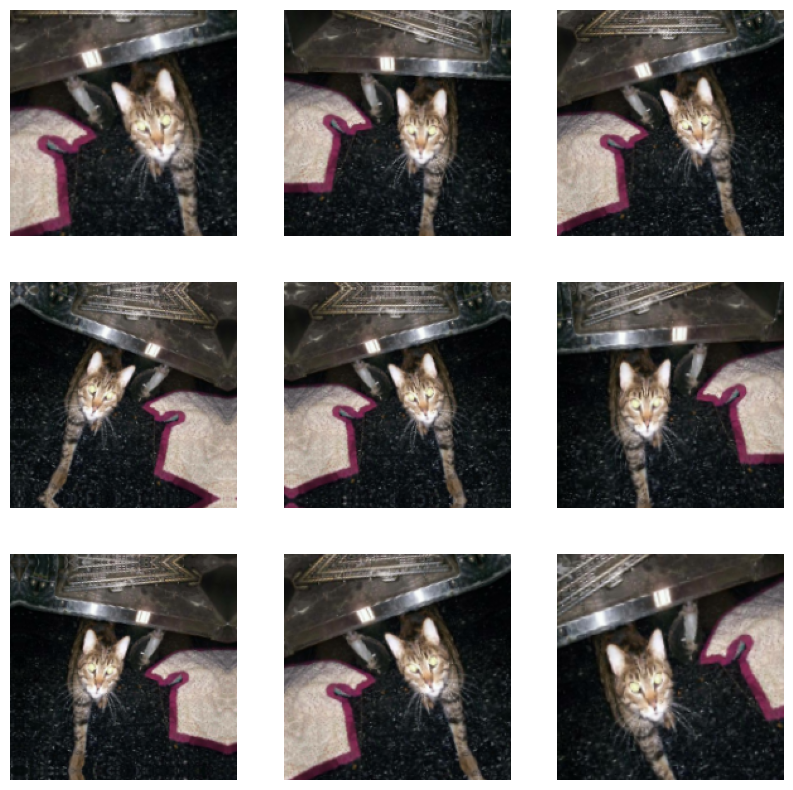

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# take(1) samples 1 batch from the dataset. equivalent to "break" in a for loop
for images, index in train_dataset.take(1):
    # For each of the nine iterations, there is a different augmentation of the same image
    for i in range(9):
        # Apply augmentation to batch of images on Sequential Model
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)

        # Display first image in output batch
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
import keras
from keras import layers
def CNN_augmentation_model():
    # Use a Functional Model API
    # Models expects RGB images of size 180 x 180 and 3 is for RGB channel
    inputs = keras.Input(shape=(180, 180, 3))

    x = data_augmentation(inputs)

    # Rescale inputs to the [0, 1] range by dividing values by 255
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)

    # Max Pooling reduces the dimensionality of images by reducing the number
    # of pixels in the feature map from prev layer.
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Flatten 3D outputs to 1D since dense layers processes vectors, which are 1D
    x = layers.Flatten()(x)

    # We add a Dropout layer to further fight overfitting
    # Dropout layers drop certain neurons from working based on chance.
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

augmented_model = CNN_augmentation_model()
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

In [ ]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
  filepath="convnet_from_scratch_with_augmentation.h5",
  save_best_only=True,
  monitor="val_loss")
]

In [ ]:
augmented_model.compile(loss="binary_crossentropy",
                          optimizer="rmsprop",
                          metrics=["accuracy"])

In [ ]:
augmented_history = augmented_model.fit(
    train_dataset,
    epochs=100,
    validation_data = validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - 201s 3s/step - loss: 0.6995 - accuracy: 0.4950 - val_loss: 0.6927 - val_accuracy: 0.5240
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 175s 3s/step - loss: 0.6940 - accuracy: 0.5005 - val_loss: 0.6925 - val_accuracy: 0.5680
Epoch 3/100
63/63 [==============================] - 169s 3s/step - loss: 0.6919 - accuracy: 0.5455 - val_loss: 0.7003 - val_accuracy: 0.5090
Epoch 4/100
63/63 [==============================] - 171s 3s/step - loss: 0.6781 - accuracy: 0.5780 - val_loss: 0.6574 - val_accuracy: 0.6110
Epoch 5/100
63/63 [==============================] - 193s 3s/step - loss: 0.6640 - accuracy: 0.6190 - val_loss: 0.6591 - val_accuracy: 0.5940
Epoch 6/100
63/63 [==============================] - 191s 3s/step - loss: 0.6534 - accuracy: 0.6150 - val_loss: 0.6781 - val_accuracy: 0.5920
Epoch 7/100
63/63 [==============================] - 169s 3s/step - loss: 0.6456 - accuracy: 0.6335 - val_loss: 0.6298 - val_accuracy: 0.6450
Epoch 8/100
63/63 [==============================] - 192s 3s/step - loss: 0.6363 - accuracy: 0.6515 - val_loss: 0.6263 - val_accuracy: 0.6400
Epoch 9/100
63/63 

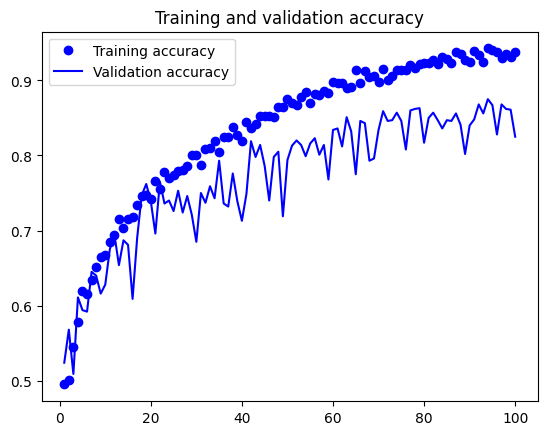

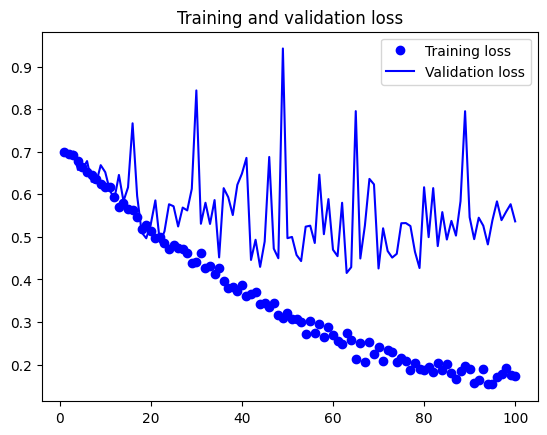

In [ ]:
plot_graph(augmented_history)

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.3f}')

63/63 [==============================] - 41s 643ms/step - loss: 0.4948 - accuracy: 0.8345
Test Accuracy: 0.835
